In [1]:
import numpy as np
import pandas as pd
import graphviz
from scipy.stats import rankdata
import pickle
from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.fitness import make_fitness

from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

import jqdatasdk as jq
import jqfactor_analyzer as ja

jq.auth('18610039264', 'zg19491001')

import warnings
warnings.filterwarnings("ignore")

提示：当前环境pandas版本为0.25，get_price与get_fundamentals_continuously接口panel参数将固定为False
注意：0.25以上版本pandas不支持panel，如使用该数据结构和相关函数请注意修改
auth success 


In [2]:
# 设置起止时间
start_date = '2019-01-01'
end_date = '2019-06-01'
fields = ['open', 'high', 'low', 'avg', 'pre_close', 'high_limit','low_limit', 'close']
stock_price = jq.get_price('000001.XSHE', start_date=start_date, end_date=end_date, fq='post', fields=fields)
stock_price['pct'] = stock_price['close'].pct_change(periods=1)


In [3]:
data = stock_price[fields].values
target = stock_price['pct'].values

test_size=0.2
test_num = int(len(data)*test_size)
X_train = data[:-test_num]
X_test = data[-test_num:]
y_train = np.nan_to_num(target[:-test_num])
y_test = np.nan_to_num(target[-test_num:])

# 定义函数

In [4]:
# 系统自带的函数群

"""
Available individual functions are:
‘add’ : addition, arity=2.
‘sub’ : subtraction, arity=2.
‘mul’ : multiplication, arity=2.
‘div’ : protected division where a denominator near-zero returns 1., arity=2.
‘sqrt’ : protected square root where the absolute value of the argument is used, arity=1.
‘log’ : protected log where the absolute value of the argument is used and a near-zero argument returns 0., arity=1.
‘abs’ : absolute value, arity=1.
‘neg’ : negative, arity=1.
‘inv’ : protected inverse where a near-zero argument returns 0., arity=1. 
‘max’ : maximum, arity=2.
‘min’ : minimum, arity=2.
‘sin’ : sine (radians), arity=1.
‘cos’ : cosine (radians), arity=1.
‘tan’ : tangent (radians), arity=1.
"""

# init_function = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan']
init_function = ['add', 'sub', 'mul', 'div']

In [5]:
# 自定义函数, make_function函数群

def _rolling_rank(data):
    value = rankdata(data)[-1]
    
    return value

def _rolling_prod(data):
    
    return np.prod(data)

def _ts_sum(data):
    window=10
    value = np.array(pd.Series(data.flatten()).rolling(window).sum().tolist())
    value = np.nan_to_num(value)

    return value

def _sma(data):
    window=10
    value = np.array(pd.Series(data.flatten()).rolling(window).mean().tolist())
    value = np.nan_to_num(value)
    
    return value

def _stddev(data):
    window=10
    value = np.array(pd.Series(data.flatten()).rolling(window).std().tolist())
    value = np.nan_to_num(value)
    
    return value

def _ts_rank(data):
    window=10
    value = np.array(pd.Series(data.flatten()).rolling(10).apply(_rolling_rank).tolist())
    value = np.nan_to_num(value)
    
    return value

def _product(data):
    window=10
    value = np.array(pd.Series(data.flatten()).rolling(10).apply(_rolling_prod).tolist())
    value = np.nan_to_num(value)
    
    return value

def _ts_min(data):
    window=10
    value = np.array(pd.Series(data.flatten()).rolling(window).min().tolist())
    value = np.nan_to_num(value)
    
    return value

def _ts_max(data):
    window=10
    value = np.array(pd.Series(data.flatten()).rolling(window).max().tolist())
    value = np.nan_to_num(value)
    
    return value

def _delta(data):
    value = np.diff(data.flatten())
    value = np.append(0, value)

    return value

def _delay(data):
    period=1
    value = pd.Series(data.flatten()).shift(1)
    value = np.nan_to_num(value)
    
    return value

def _rank(data):
    value = np.array(pd.Series(data.flatten()).rank().tolist())
    value = np.nan_to_num(value)
    
    return value

def _scale(data):
    k=1
    data = pd.Series(data.flatten())
    value = data.mul(1).div(np.abs(data).sum())
    value = np.nan_to_num(value)
    
    return value

def _ts_argmax(data):
    window=10
    value = pd.Series(data.flatten()).rolling(10).apply(np.argmax) + 1 
    value = np.nan_to_num(value)
    
    return value

def _ts_argmin(data):
    window=10
    value = pd.Series(data.flatten()).rolling(10).apply(np.argmin) + 1 
    value = np.nan_to_num(value)
    
    return value

# make_function函数群
delta = make_function(function=_delta, name='delta', arity=1)
delay = make_function(function=_delay, name='delay', arity=1)
rank = make_function(function=_rank, name='rank', arity=1)
scale = make_function(function=_scale, name='scale', arity=1)
sma = make_function(function=_sma, name='sma', arity=1)
stddev = make_function(function=_stddev, name='stddev', arity=1)
product = make_function(function=_product, name='product', arity=1)
ts_rank = make_function(function=_ts_rank, name='ts_rank', arity=1)
ts_min = make_function(function=_ts_min, name='ts_min', arity=1)
ts_max = make_function(function=_ts_max, name='ts_max', arity=1)
ts_argmax = make_function(function=_ts_argmax, name='ts_argmax', arity=1)
ts_argmin = make_function(function=_ts_argmin, name='ts_argmin', arity=1)
ts_sum = make_function(function=_ts_sum, name='ts_sum', arity=1)

user_function = [delta, delay, rank, scale, sma, stddev, product, ts_rank, ts_min, ts_max, ts_argmax, ts_argmin, ts_sum]

In [6]:
# 定义适应度
def _my_metric(y, y_pred, w):
    value = np.sum(np.abs(y) + np.abs(y_pred))

    return value
my_metric = make_fitness(function=_my_metric, greater_is_better=True)

In [7]:
# 生成表达式
generations = 5
function_set = init_function + user_function
metric = my_metric
population_size = 100
random_state=0
est_gp = SymbolicTransformer(
                            feature_names=fields, 
                            function_set=function_set,
                            generations=generations,
                            metric=metric,
                            population_size=population_size,
                            tournament_size=20, 
                            random_state=random_state,
                         )

est_gp.fit(X_train, y_train)

# 将模型保存到本地
with open('gp_model.pkl', 'wb') as f:
    pickle.dump(est_gp, f)

In [8]:
# 获取较优的表达式

best_programs = est_gp._best_programs
best_programs_dict = {}
for p in best_programs:
    factor_name = 'alpha_' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}
     
best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict.sort_values(by='fitness')
best_programs_dict 

,fitness,expression,depth,length
alpha_10,325.906,"delta(div(stddev(stddev(ts_max(avg))), stddev(...",5,10
alpha_9,413.386,"sub(ts_rank(delay(mul(delta(sma(open)), div(ts...",6,18
alpha_8,1920.03,delta(pre_close),1,2
alpha_7,2802.3,delta(delay(delay(open))),3,4
alpha_5,3241.39,"rank(ts_rank(div(high, pre_close)))",3,5
alpha_6,3241.4,rank(ts_rank(ts_argmin(high_limit))),3,4
alpha_4,19240.9,"mul(delay(mul(rank(ts_argmin(delta(low))), ts_...",6,20
alpha_3,7.74627e+10,product(ts_argmin(product(ts_rank(pre_close)))),4,5
alpha_2,1.31043e+15,product(delta(close)),2,3
alpha_1,2.53308e+50,"mul(product(sub(open, ts_sum(close))), ts_max(...",5,14


In [9]:
def alpha_factor_graph(num):
    # 打印指定num的表达式图

    factor = best_programs[num-1]
    print(factor)
    print('fitness: {0}, depth: {1}, length: {2}'.format(factor.fitness_, factor.depth_, factor.length_))

    dot_data = factor.export_graphviz()
    graph = graphviz.Source(dot_data)
    #graph.render('c:/e/fig/alpha_factor_graph', format='png', cleanup=True)
    
    return graph

In [10]:
# 使用表达式构建因子（以alpha_10为例）
# 打印因子alpha_10的结构图

graph10 = alpha_factor_graph(10)
graph10

delta(div(stddev(stddev(ts_max(avg))), stddev(ts_rank(ts_argmin(close)))))
fitness: 325.9056451860095, depth: 5, length: 10


ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [11]:
# alpha_10 delta(div(stddev(stddev(ts_max(avg))), stddev(ts_rank(ts_argmin(close)))))

def alpha_10(df):
    value1 = _stddev(_stddev(_ts_max(np.array(df['avg'].tolist()))))
    value2 = _stddev(_ts_rank(_ts_argmin(np.array(df['close'].tolist()))))
    value = delta(value1/value2)

    return value
    
stock_price['alpha_10'] = alpha_10(stock_price)

# 单因子分析构建的因子

In [12]:
# 设置起止时间
start_date = '2019-01-01'
end_date = '2019-06-01'

# 设置调仓周期
periods=(1, 5, 20)
# 设置分层数量
quantiles=5

# 设置股票池
scu='000300.XSHG'
securities = jq.get_index_stocks(scu)

In [13]:
# 获取需要分析的数据

factor_data = pd.DataFrame(columns=securities, index=stock_price.index)
for security in securities:
    stock_price = jq.get_price(security, start_date=start_date, end_date=end_date, fq='post', fields=fields)
    stock_price['pct'] = stock_price['close'].pct_change(periods=1)
    stock_price['alpha_10'] = alpha_10(stock_price)
    
    factor_data[security] = stock_price['alpha_10']

In [14]:
# 使用获取的因子值进行单因子分析
far = ja.analyze_factor(factor=factor_data, 
                        weight_method='avg', 
                        industry='jq_l1', 
                        quantiles=quantiles, 
                        periods=periods,
                        max_loss=0.25)

分位数统计


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-209.743577,0.323632,-1.631770,7.843735,5207,20.154049
2,-8.593162,0.817967,-0.191629,0.841668,5159,19.968261
3,-3.453265,2.260151,-0.016643,0.399749,5137,19.883109
4,-1.491825,7.062899,0.148698,0.628193,5159,19.968261
5,-0.471546,196.544053,1.381119,5.951991,5174,20.026320



-------------------------

收益分析


,period_1,period_5,period_20
Ann. alpha,0.159,0.411,0.030
beta,-0.067,0.001,0.142
Mean Period Wise Return Top Quantile (bps),28.863,23.674,23.648
Mean Period Wise Return Bottom Quantile (bps),23.533,16.488,21.834
Mean Period Wise Spread (bps),5.329,7.150,1.685


<Figure size 432x288 with 0 Axes>

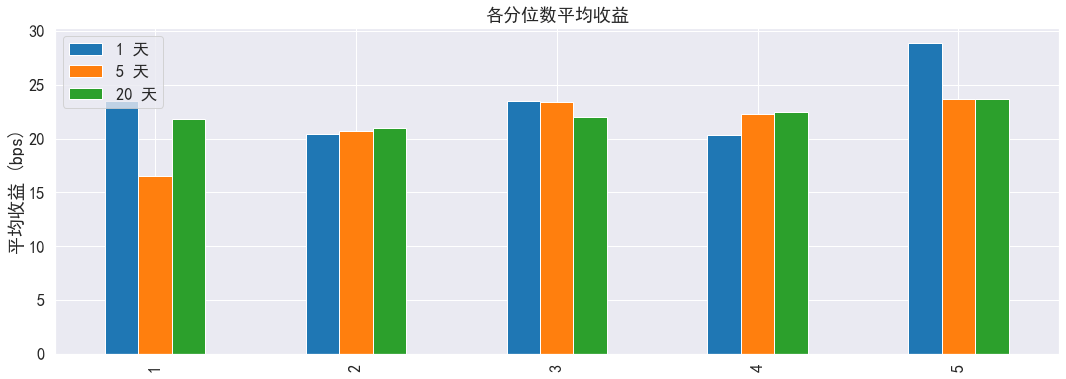

<Figure size 432x288 with 0 Axes>

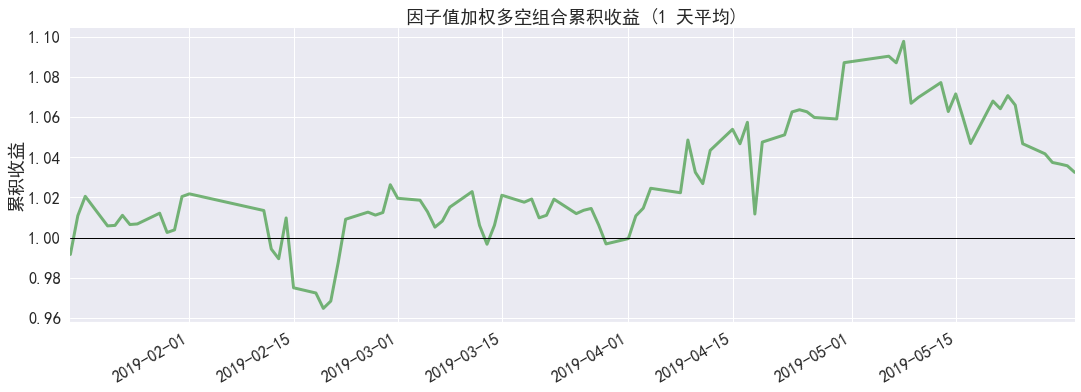

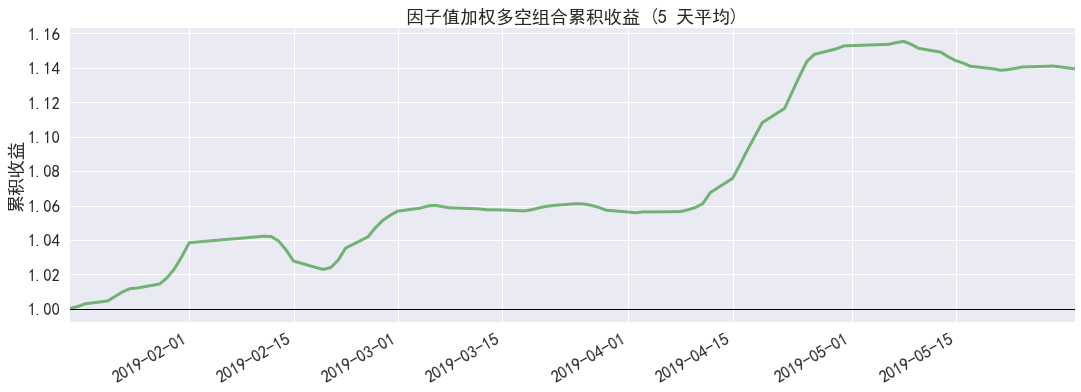

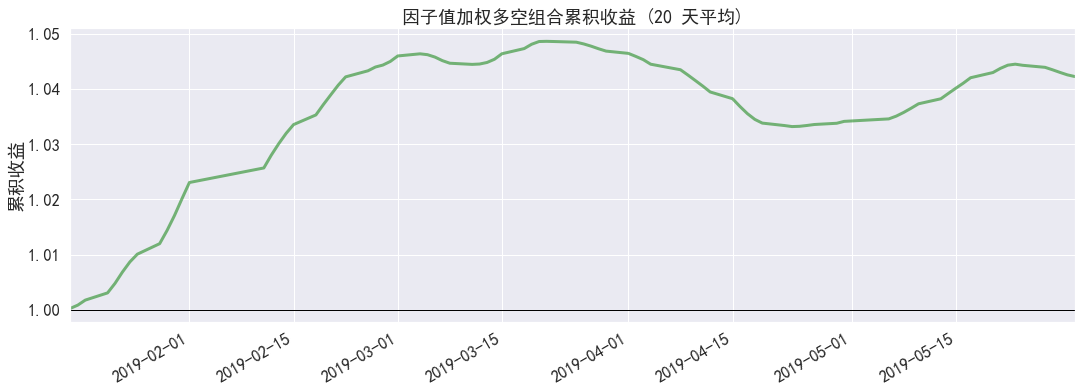

<Figure size 432x288 with 0 Axes>

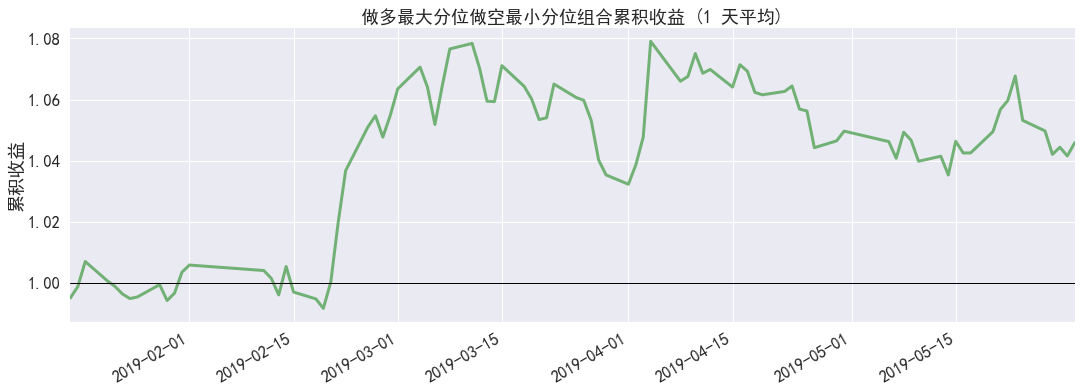

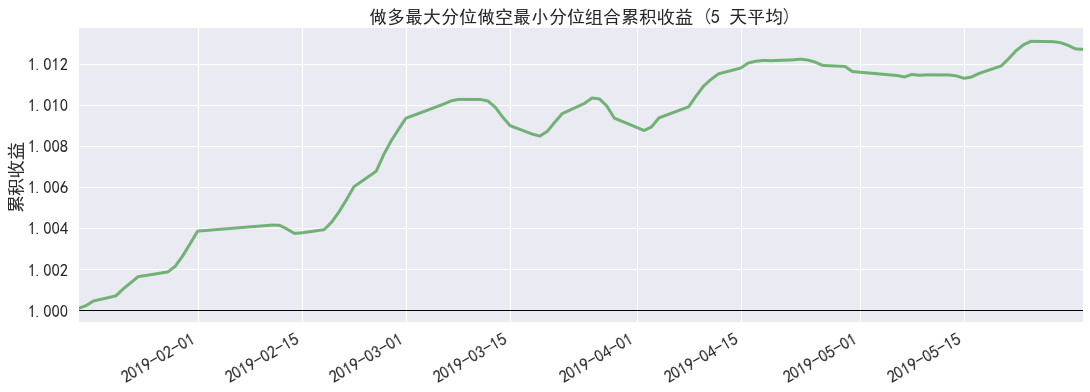

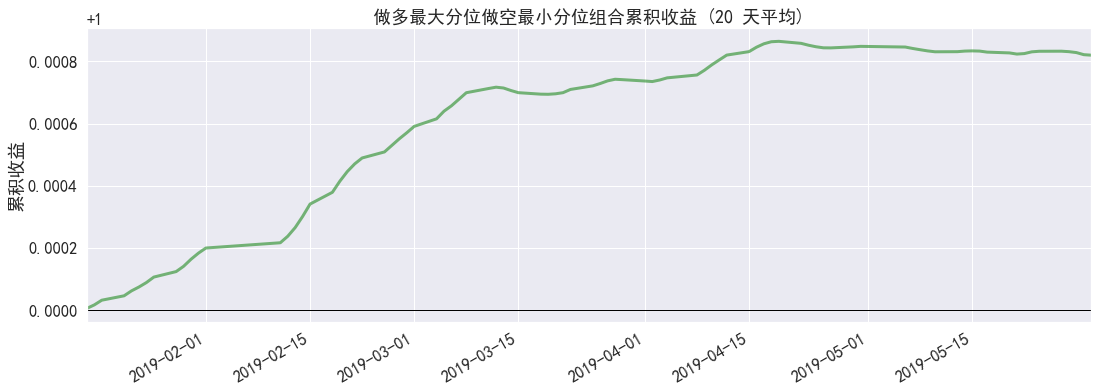

<Figure size 432x288 with 0 Axes>

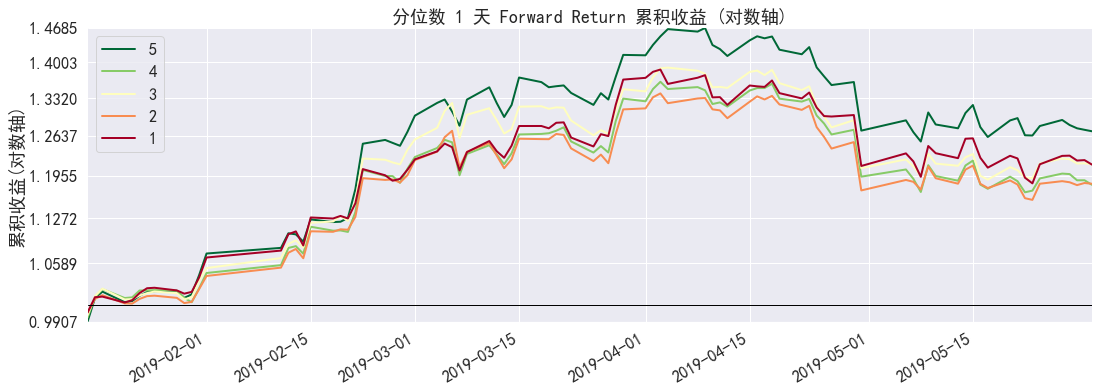

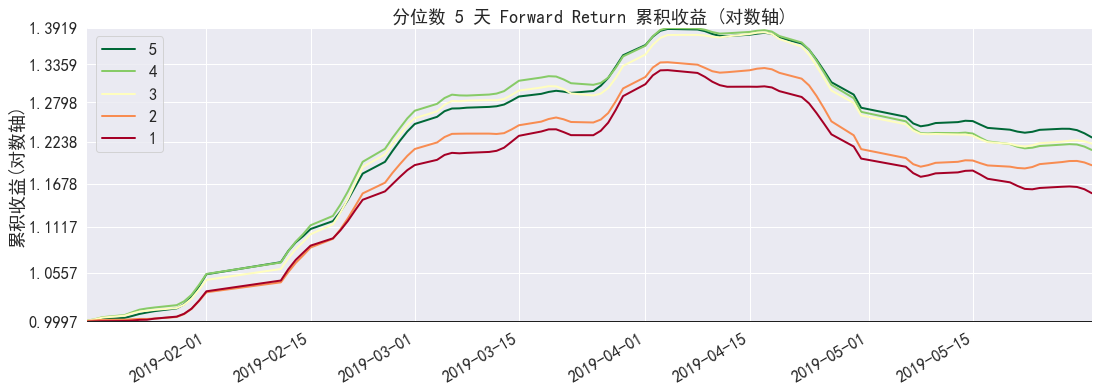

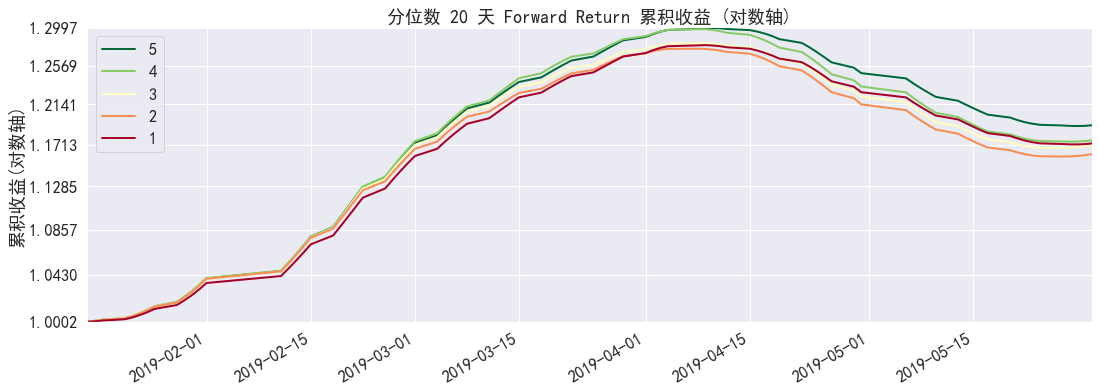

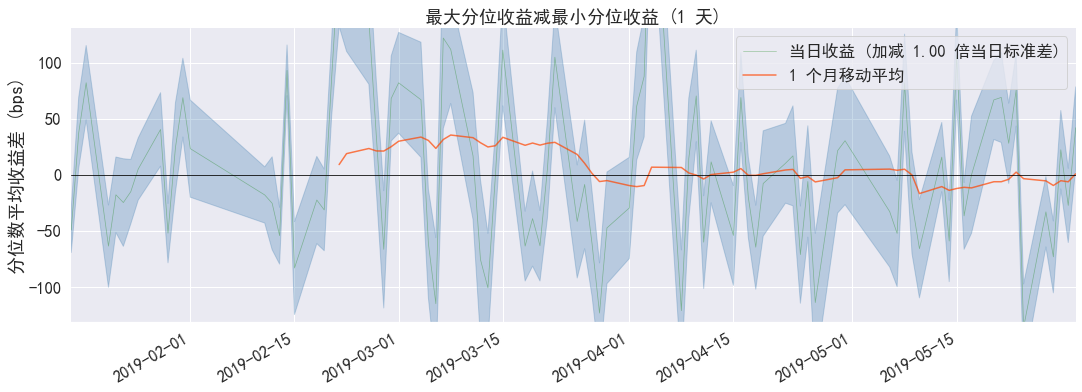

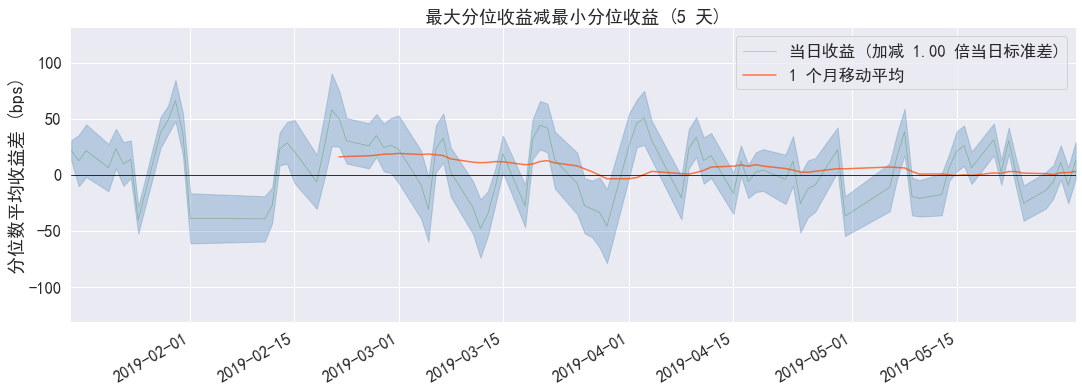

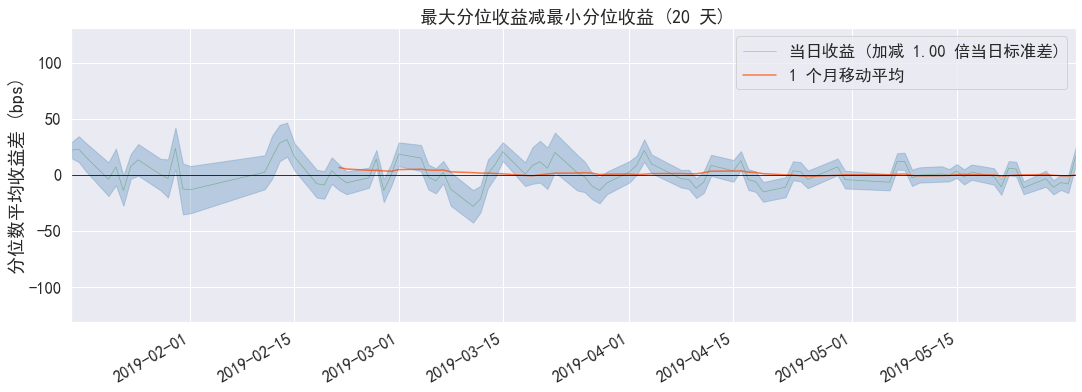

<Figure size 432x288 with 0 Axes>

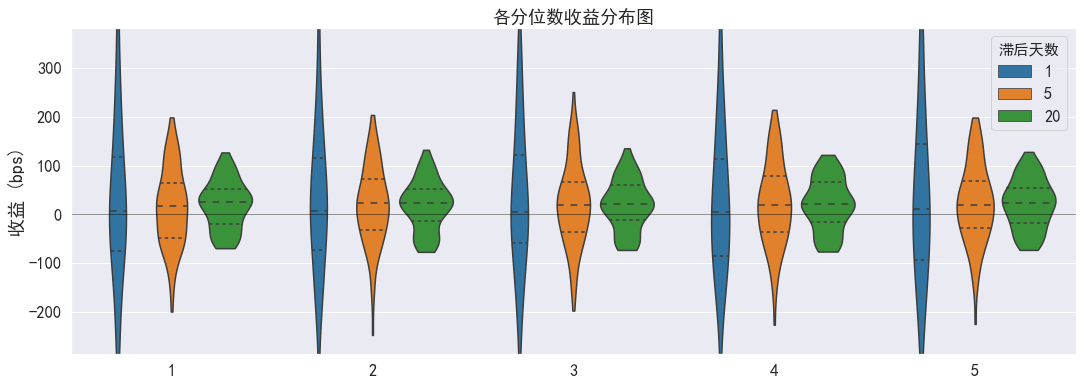


-------------------------

IC 分析


,period_1,period_5,period_20
IC Mean,-0.003,0.021,0.003
IC Std.,0.105,0.107,0.087
IR,-0.026,0.198,0.034
t-stat(IC),-0.245,1.867,0.319
p-value(IC),0.807,0.065,0.751
IC Skew,0.415,0.282,0.419
IC Kurtosis,-0.440,-0.292,-0.078


<Figure size 432x288 with 0 Axes>

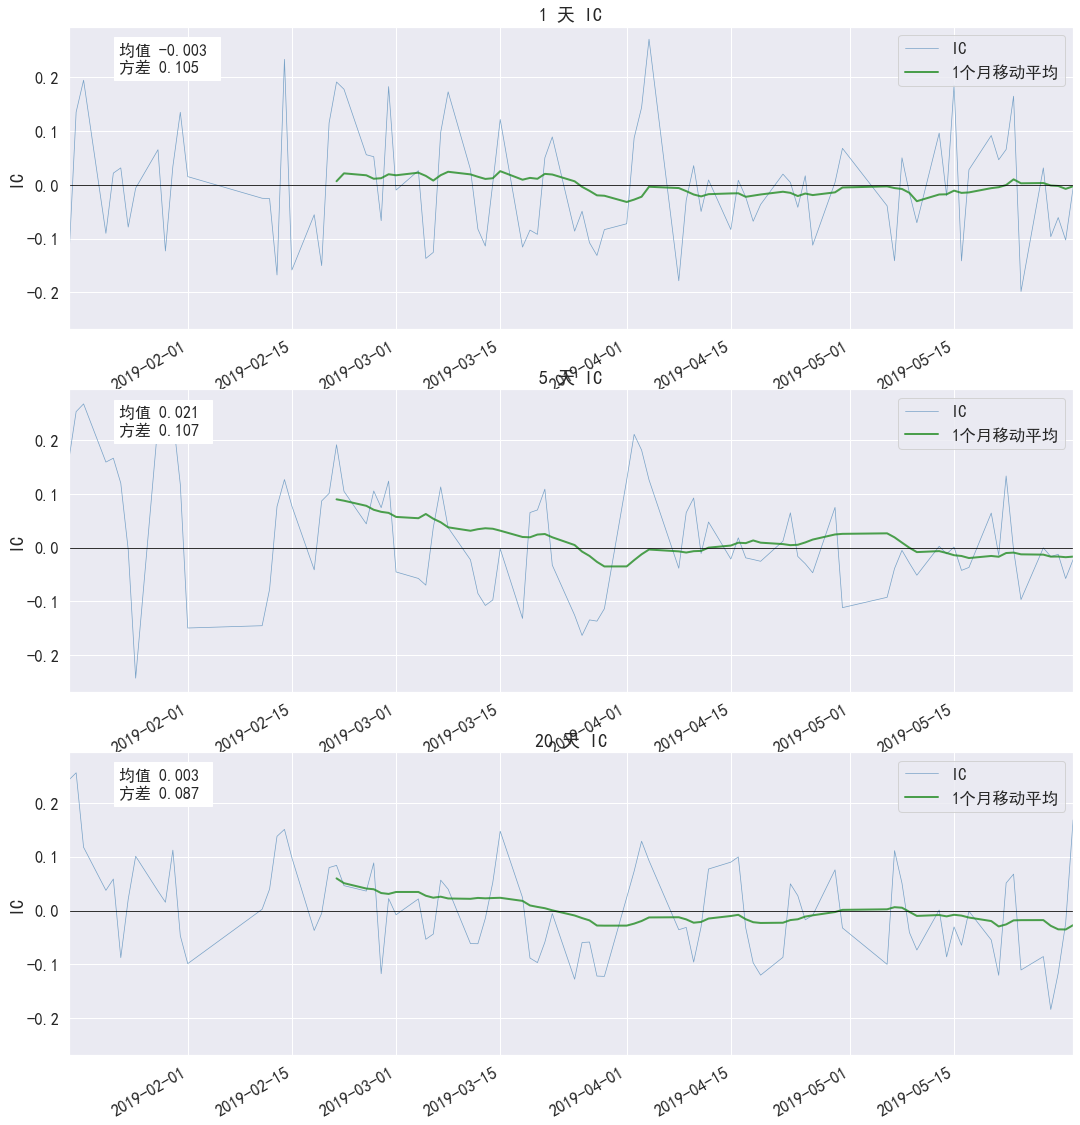

<Figure size 432x288 with 0 Axes>

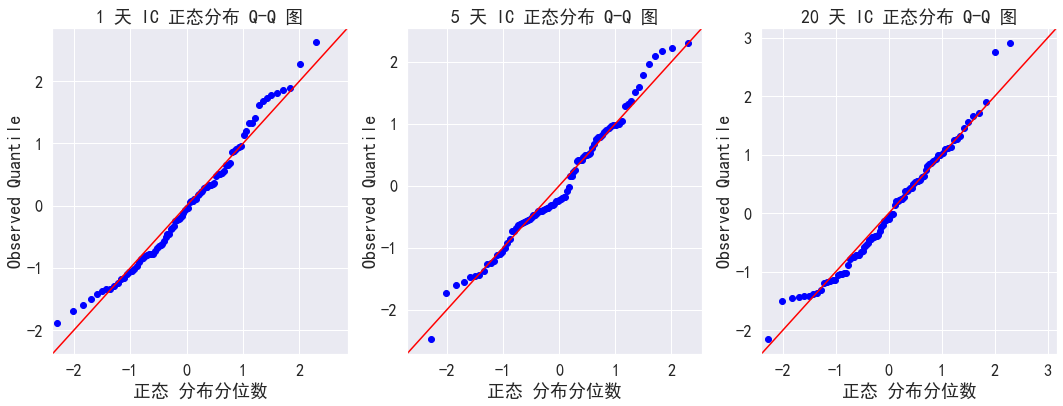

<Figure size 432x288 with 0 Axes>

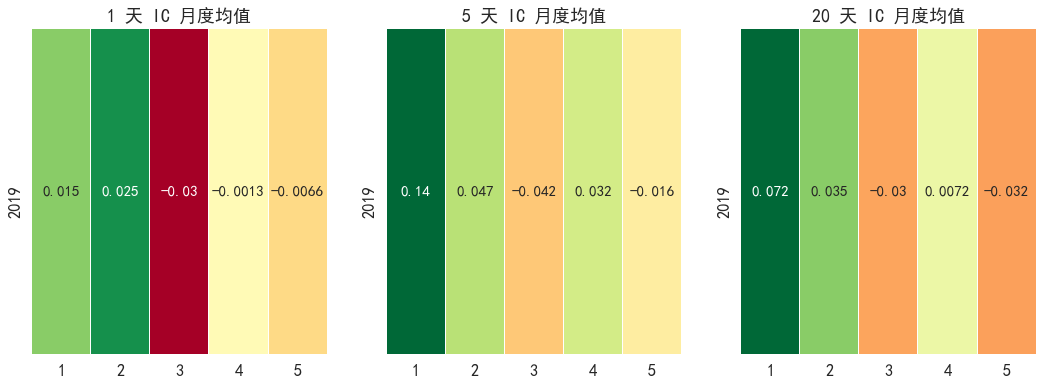


-------------------------

换手率分析


,period_1,period_20,period_5
Quantile 1 Mean Turnover,0.399,0.701,0.765
Quantile 2 Mean Turnover,0.526,0.775,0.812
Quantile 3 Mean Turnover,0.489,0.665,0.613
Quantile 4 Mean Turnover,0.524,0.772,0.802
Quantile 5 Mean Turnover,0.362,0.689,0.765


,period_1,period_5,period_20
Mean Factor Rank Autocorrelation,0.54,-0.223,-0.01


<Figure size 432x288 with 0 Axes>

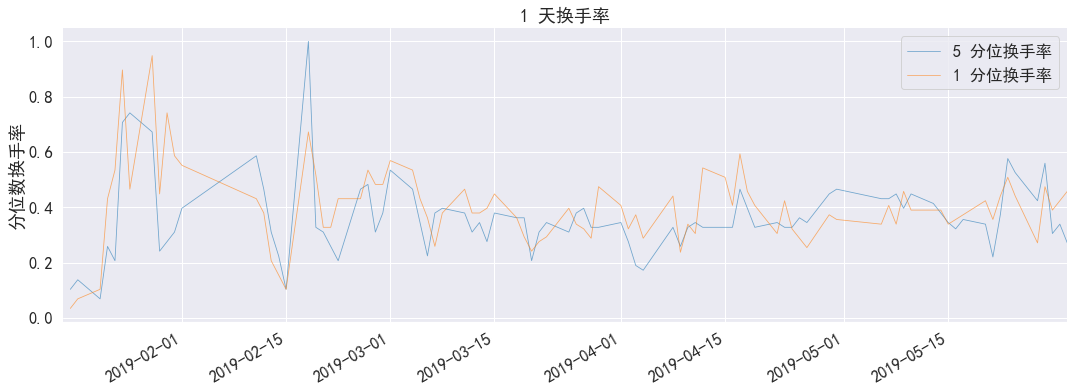

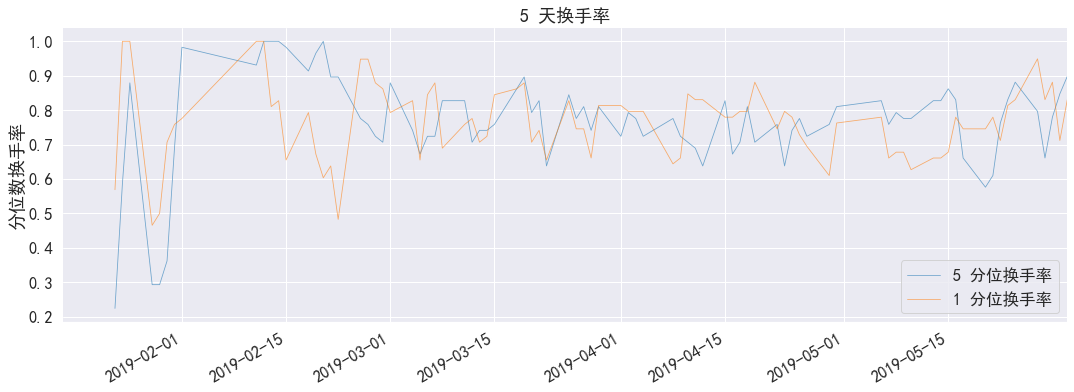

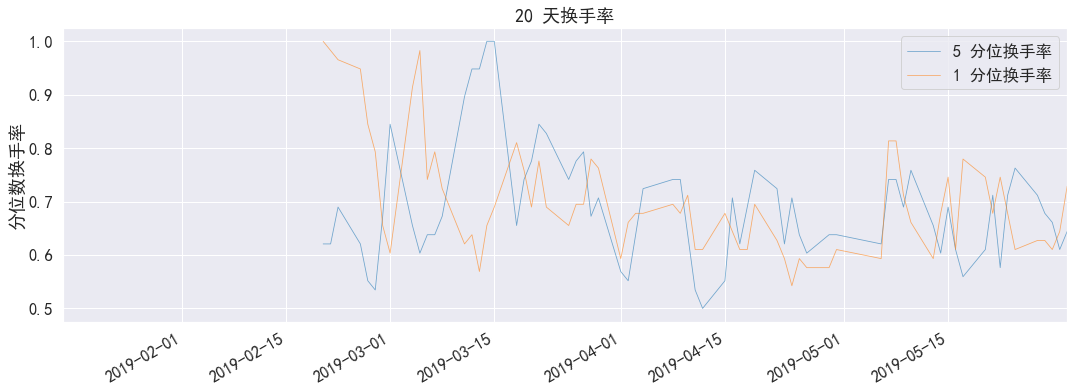

<Figure size 432x288 with 0 Axes>

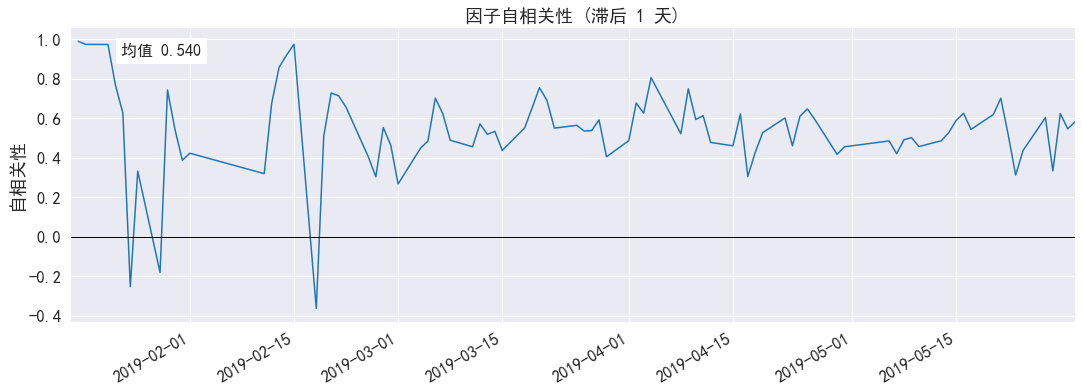

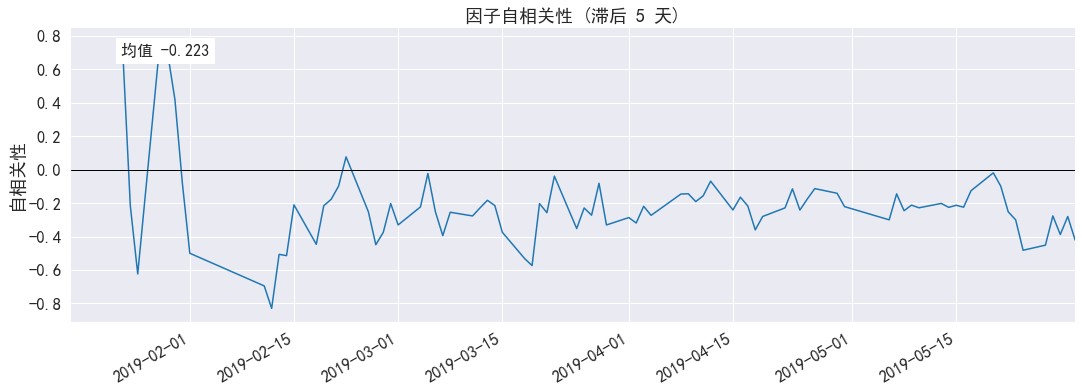

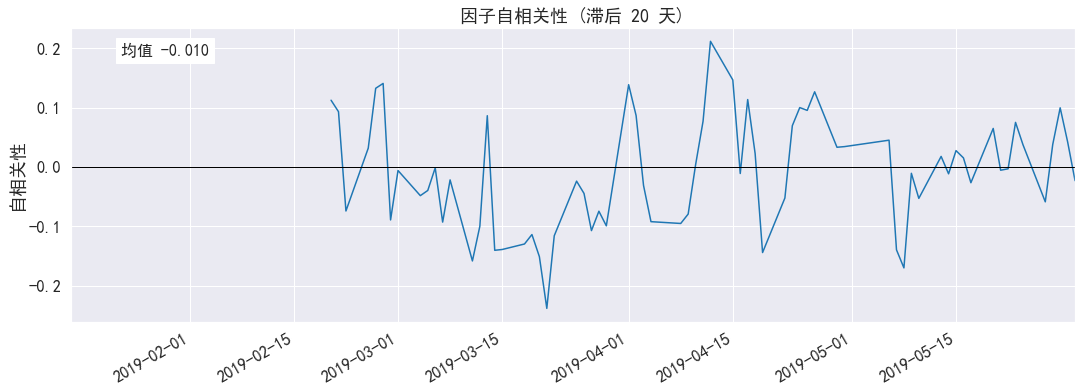


-------------------------



<Figure size 432x288 with 0 Axes>

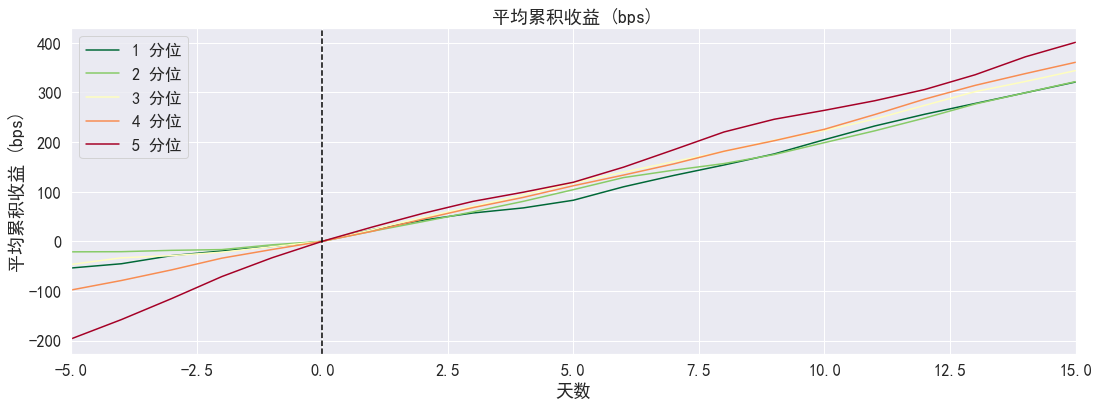

In [15]:
# 生成统计图表
far.create_full_tear_sheet(
    demeaned=False, group_adjust=False, by_group=False,
    turnover_periods=None, avgretplot=(5, 15), std_bar=False
)